# Accessing Training Metrics

We create a metric_definition dictionary that contains regex-based definitions that will be used to parse the job logs and extract metrics.

```python
metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

huggingface_estimator = HuggingFace(
    entry_point='train.py',
    source_dir='./scripts',
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions)
```

[ToBeSolved] seaborn has issue to plot the metrics: OptionError: No such keys(s): 'mode.use_inf_as_null'.

In [2]:
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import sagemaker.huggingface

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [4]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

sagemaker role arn: arn:aws:iam::802575742115:role/service-role/AmazonSageMaker-ExecutionRole-20230929T143152
sagemaker bucket: sagemaker-us-east-1-802575742115
sagemaker session region: us-east-1


## Load Data Sets

In [5]:
from datasets import load_dataset, VerificationMode
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset('imdb', split=['train', 'test'], verification_mode=VerificationMode.NO_CHECKS)
test_dataset = test_dataset.shuffle().select(range(10000)) # smaller the size for test dataset to 10k 

print(train_dataset[0:2])

# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

print(train_dataset[0:2])

# input_ids are tokenized and mapped to corresponding indices in the model's vocabulary.

# segment_ids 
# BERT was designed to handle tasks involving multiple sentences. segment_ids are used to distinguish different sentences in the input.
# For a single sentence task, all elements in segment_ids would be set to 0. For tasks involving multiple sentences, you might have alternating 0s and 1s to indicate different segments.

# attention_mask:
# BERT models have a fixed input size, the attention mask is used to indicate which elements of the input sequence are actual tokens versus padding tokens.
# 0 indicates it is a padding token. This mask helps the model focus only on the relevant tokens and ignore the padding tokens during training.

# set format for pytorch
# set_format('torch'): This method is used to set the format of the dataset to be compatible with PyTorch. 
# columns=['input_ids', 'attention_mask', 'labels']: This specifies which columns of the dataset should be converted to PyTorch tensors. 
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

print(train_dataset[0:2])

Found cached dataset parquet (/root/.cache/huggingface/datasets/parquet/plain_text-745310791ff4d097/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/parquet/plain_text-745310791ff4d097/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-ec473c0cf9d9f4ca.arrow


{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

## Uploading data to sagemaker_session_bucket

In [6]:
# s3 key prefix for the data
s3_prefix = 'samples/datasets/imdb'

# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path)

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10000 [00:00<?, ? examples/s]

## Launching a Training Job with custom metrics

We create a metric_definition dictionary that contains regex-based definitions that will be used to parse the job logs and extract metrics

In [7]:
from sagemaker.huggingface import HuggingFace

# hyperparameters, which will be passed into the training job
hyperparameters={
    'epochs': 3,
    'train_batch_size': 32,
    'checkpoints': '/opt/ml/checkpoints/',
    'model_name':'distilbert-base-uncased'
}


metric_definitions=[
    {'Name': 'loss', 'Regex': "'loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'learning_rate', 'Regex': "'learning_rate': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_loss', 'Regex': "'eval_loss': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_accuracy', 'Regex': "'eval_accuracy': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_f1', 'Regex': "'eval_f1': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_precision', 'Regex': "'eval_precision': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_recall', 'Regex': "'eval_recall': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_runtime', 'Regex': "'eval_runtime': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'eval_samples_per_second', 'Regex': "'eval_samples_per_second': ([0-9]+(.|e\-)[0-9]+),?"},
    {'Name': 'epoch', 'Regex': "'epoch': ([0-9]+(.|e\-)[0-9]+),?"}]

huggingface_estimator = HuggingFace(
    entry_point='train.py',
    source_dir='./scripts',
    instance_type='ml.p3.2xlarge',
    instance_count=1,
    transformers_version='4.26',
    pytorch_version='1.13',
    py_version='py39',
    role=role,
    hyperparameters=hyperparameters,
    metric_definitions=metric_definitions)

In [8]:
# starting the train job with our uploaded datasets as input
huggingface_estimator.fit({'train': training_input_path, 'test': test_input_path})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: huggingface-pytorch-training-2024-01-23-19-31-19-252


2024-01-23 19:31:20 Starting - Starting the training job
2024-01-23 19:31:20 Pending - Training job waiting for capacity......
2024-01-23 19:32:19 Pending - Preparing the instances for training.........
2024-01-23 19:33:43 Downloading - Downloading input data...
2024-01-23 19:34:13 Downloading - Downloading the training image...........................
2024-01-23 19:38:49 Training - Training image download completed. Training in progress....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-01-23 19:39:08,009 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-01-23 19:39:08,029 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-01-23 19:39:08,042 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-01-23 19:39:08,045 sagemaker_pytorch_container.training INFO     Invoking user training script.
2

## Accessing Training Metrics

The training job doesn't emit metrics immediately. For example, it first needs to provision a training instance, download the training image, download the data. Additionally in this demo the first evaluation logs come after 500 steps (default in the Hugging Face trainer https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments).

Hence, run the below section 15 to 20 minutes after launching the training, otherwise it may not have available metrics yet and return an error

Note that you can also copy this code and run it from a different place (as long as connected to the cloud and authorized to use the API), by specifiying the exact training job name in the TrainingJobAnalytics API call.)

In [9]:
from sagemaker import TrainingJobAnalytics

# Captured metrics can be accessed as a Pandas dataframe
df = TrainingJobAnalytics(training_job_name=huggingface_estimator.latest_training_job.name).dataframe()
df.head(10)

,timestamp,metric_name,value
0,0.0,loss,0.350400
1,240.0,loss,0.217500
2,480.0,loss,0.148800
3,780.0,loss,0.074700
4,0.0,learning_rate,0.000050
5,240.0,learning_rate,3.645720
6,480.0,learning_rate,2.291441
7,780.0,learning_rate,9.371614
8,0.0,eval_loss,0.202179
9,420.0,eval_loss,0.222734


We can also plot some of the metrics collected

Note: the plot below were generated at the end of the training job, with metrics available for all training duration

In [27]:
!pip install --upgrade seaborn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [28]:
from matplotlib import pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [15,5]

    timestamp     metric_name     value
11        0.0   eval_accuracy  0.923500
12      420.0   eval_accuracy  0.928400
13      780.0   eval_accuracy  0.932500
17        0.0  eval_precision  0.913854
18      420.0  eval_precision  0.952684
19      780.0  eval_precision  0.925355


    timestamp metric_name     value
0         0.0        loss  0.350400
1       240.0        loss  0.217500
2       480.0        loss  0.148800
3       780.0        loss  0.074700
8         0.0   eval_loss  0.202179
9       420.0   eval_loss  0.222734
10      780.0   eval_loss  0.267226


/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


OptionError: No such keys(s): 'mode.use_inf_as_null'

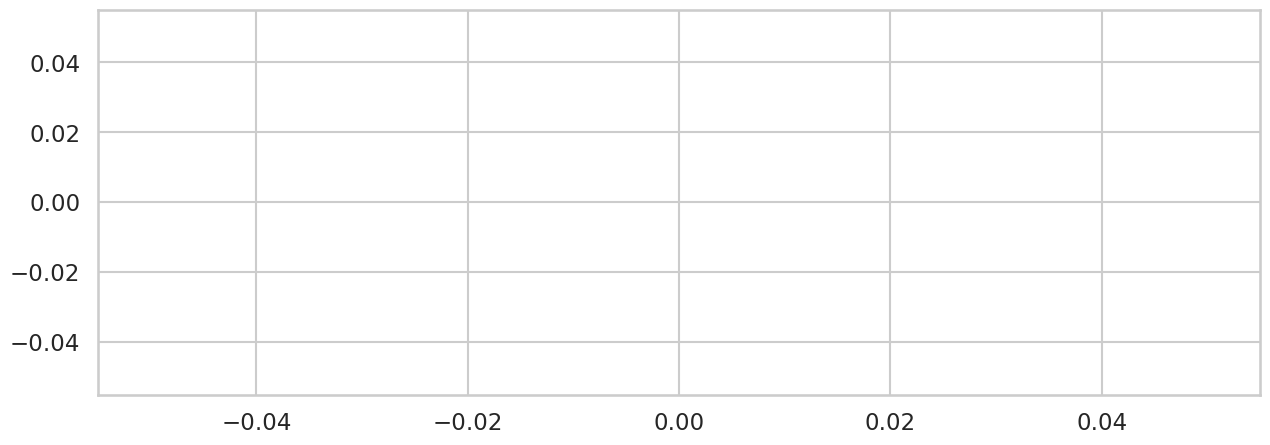

In [33]:
evals = df[df.metric_name.isin(['eval_accuracy','eval_precision'])]
losses = df[df.metric_name.isin(['loss', 'eval_loss'])]

print(evals)
print("\n")
print(losses)

sns.lineplot(
    x='timestamp', 
    y='value', 
    data=evals, 
    hue='metric_name', 
    palette=['blue', 'purple'])

ax2 = plt.twinx()
sns.lineplot(
    x='timestamp', 
    y='value', 
    data=losses, 
    hue='metric_name', 
    palette=['orange', 'red'],
    ax=ax2)